In [370]:
import warnings
warnings.filterwarnings(action='ignore')

# Influenza Type Classifer

In [371]:
import pandas as pd
df1=pd.read_csv("../input/flureports/lab flu confirmed 2008-2013.csv")
df2 =pd.read_csv("../input/flureports/lab flu confirmed 2014 - 2019.csv")

df1= df1.iloc[:, 0:6]
df1.head()

,Week Ending (Friday),State,Age group,Sex,Indigenous status,Type/Subtype
0,03/01/2014,NSW,35-39,Female,not available,A(H3N2)
1,03/01/2014,NSW,80-84,Female,not available,A(unsubtyped)
2,03/01/2014,NSW,80-84,Male,not available,A(unsubtyped)
3,03/01/2014,NSW,85+,Female,not available,A(H3N2)
4,03/01/2014,NT,00-04,Male,non-Indigenous,B


In [372]:
df2= df2.iloc[:, 0:6]
df2.head()

,Week Ending (Friday),State,Age group,Sex,Indigenous status,Type/Subtype
0,03/01/2020,NSW,00-04,Female,not available,A(H1N1)pdm09
1,03/01/2020,NSW,00-04,Female,not available,A(unsubtyped)
2,03/01/2020,NSW,00-04,Female,not available,A(unsubtyped)
3,03/01/2020,NSW,00-04,Male,not available,A(unsubtyped)
4,03/01/2020,NSW,00-04,Male,not available,A(unsubtyped)


In [373]:
#put the two df's together
df = pd.concat([df2, df1], axis=0)
df.head()
print(len(df))

1049869


In [374]:
# create labels
flu_types= df['Type/Subtype'].unique()
print(flu_types)

['A(H1N1)pdm09' 'A(unsubtyped)' 'B' 'A(H3N2)' 'A and B' 'Untyped' 'C'
 'A(H1N1)']


In [375]:
risk = ['pandemic_H1', 'pandemic_unknown', 'seasonal', 'pandemic_H3', 'seasonal_mixed', 'unknown', 'low_risk', 'pre-pandemic']

In [376]:
#create dictionary
risk_dict= dict(zip(flu_types, risk))
print(risk_dict)

{'A(H1N1)pdm09': 'pandemic_H1', 'A(unsubtyped)': 'pandemic_unknown', 'B': 'seasonal', 'A(H3N2)': 'pandemic_H3', 'A and B': 'seasonal_mixed', 'Untyped': 'unknown', 'C': 'low_risk', 'A(H1N1)': 'pre-pandemic'}


In [377]:
#replace class column with classification
df['Class'] = df['Type/Subtype']
df.head()
flu=df.replace({"Class": risk_dict})
flu.head()

,Week Ending (Friday),State,Age group,Sex,Indigenous status,Type/Subtype,Class
0,03/01/2020,NSW,00-04,Female,not available,A(H1N1)pdm09,pandemic_H1
1,03/01/2020,NSW,00-04,Female,not available,A(unsubtyped),pandemic_unknown
2,03/01/2020,NSW,00-04,Female,not available,A(unsubtyped),pandemic_unknown
3,03/01/2020,NSW,00-04,Male,not available,A(unsubtyped),pandemic_unknown
4,03/01/2020,NSW,00-04,Male,not available,A(unsubtyped),pandemic_unknown


In [378]:
flu.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1049869 entries, 0 to 178631
Data columns (total 7 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   Week Ending (Friday)  1049869 non-null  object
 1   State                 1049869 non-null  object
 2   Age  group            1049869 non-null  object
 3   Sex                   1049869 non-null  object
 4   Indigenous status     1049869 non-null  object
 5   Type/Subtype          1049869 non-null  object
 6   Class                 1049869 non-null  object
dtypes: object(7)
memory usage: 64.1+ MB


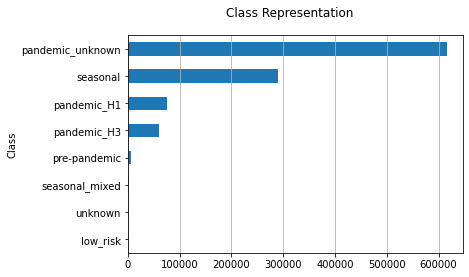

In [379]:
# Label frequency
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.suptitle("Class Representation", fontsize=12)
flu["Class"].reset_index().groupby("Class").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

# Pre-processing for Text Classification

In [380]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize and fit CountVectorizer with given text documents
vectorizer = CountVectorizer(analyzer='char').fit(flu['Type/Subtype'])

# use the vectorizer to transform the document into word count vectors (Sparse)
word_mat = vectorizer.transform(flu['Type/Subtype'])

KeyboardInterrupt: 

In [ ]:
from sklearn.preprocessing import LabelEncoder
# creating instance of labelencoder
labelencoder = LabelEncoder()
# using the encoder to encode the categorical columns
y = labelencoder.fit_transform(flu['Class'])

## Split Data

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(word_mat, y, test_size=0.3)

# Modeling
### Training

In [ ]:
# Model Training
from sklearn.naive_bayes import MultinomialNB

from sklearn.linear_model import LogisticRegression
# instantiate the model as clf(classifier) and train it
clf = MultinomialNB()
clf.fit(x_train, y_train)

mod = LogisticRegression()
mod.fit(x_train, y_train)


## Prediction / Evaluation

In [ ]:
#make class predictions
pred = clf.predict(x_test)
#transform labels back to text
preds = labelencoder.inverse_transform(pred)
preds

#make class predictions
predm = mod.predict(x_test)
#transform labels back to text
predsm = labelencoder.inverse_transform(predm)
predsm

In [ ]:
#Transform test target back to text
yt= labelencoder.inverse_transform(y_test)
yt
ytm= labelencoder.inverse_transform(y_test)
yt

In [ ]:
# confusiong matrix
# Creating  a confusion matrix,which compares the y_test and y_pred
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(yt, preds)

cm2 = confusion_matrix(ytm, predsm)


In [ ]:
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = ['pandemic_H1', 'pandemic_unknown', 'seasonal', 'pandemic_H3', 'seasonal_mixed', 'unknown', 'low_risk', 'pre-pandemic'], 
                     columns = ['pandemic_H1', 'pandemic_unknown', 'seasonal', 'pandemic_H3', 'seasonal_mixed', 'unknown', 'low_risk', 'pre-pandemic'])


cm_df2 = pd.DataFrame(cm2,
                     index = ['pandemic_H1', 'pandemic_unknown', 'seasonal', 'pandemic_H3', 'seasonal_mixed', 'unknown', 'low_risk', 'pre-pandemic'], 
                     columns = ['pandemic_H1', 'pandemic_unknown', 'seasonal', 'pandemic_H3', 'seasonal_mixed', 'unknown', 'low_risk', 'pre-pandemic'])

In [ ]:
import seaborn as sns
import numpy as np
#Plotting the confusion matrix of Multinomial Bayes
plt.figure(figsize=(10,6))
sns.heatmap(cm_df/np.sum(cm_df), annot=True, cmap='Blues', fmt='.2%')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
import seaborn as sns
import numpy as np
#Plotting the confusion matrix of Logistic Regesssor
plt.figure(figsize=(10,6))
sns.heatmap(cm_df2/np.sum(cm_df2), annot=True, cmap='Reds', fmt='.2%')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
#serialise logistic regressor
filename = 'flu_class.sav'
pickle. dump(mod, open(filename, 'wb'))

# Epidemic Predictor

In [ ]:
#load data
#df2=pd.read_csv("../input/flureports/FluNetInteractiveReport.csv")
#df2.head(1)
data=pd.read_csv("../input/flureports/WPOFluNetInteractiveReport.csv", parse_dates=['EDATE'], index_col='EDATE', skiprows=3)
data.tail(1)

## EDA

In [ ]:
nan_values= data.isna()
nan_columns = nan_values.any()
#columns_with_nan = df.columns[nan_columns].tolist()
print(nan_columns)

In [ ]:
data.dtypes

In [ ]:
data = data.fillna(0) #fill any remaining gaps with 0
_=data.pop('SPEC_RECEIVED_NB') #remove the number of specimen received
_=data.pop('SPEC_PROCESSED_NB') #remove the number of specimen processed
data['SDATE'] = pd.to_datetime(data['SDATE']) #from object to datetime
data.head()

In [ ]:
# data = data.fillna(0)
# nan_values= data.isna()
# nan_columns = nan_values.any()
# #columns_with_nan = df.columns[nan_columns].tolist()
# print(nan_columns)

In [ ]:
target=data.pop('TITLE')
one_hot_encoded_data = pd.get_dummies(data)
one_hot_encoded_data.tail()

In [ ]:
cat_data=one_hot_encoded_data
df_inf=cat_data.resample('1m').mean()
df2_inf=cat_data.resample('1y').mean()
#check for seasonality, trend, 
fig, axes = plt.subplots(1,3, figsize=(20,4), dpi=100)
cat_data.plot(title='All influenza', legend=False, ax=axes[0])
df_inf.plot(title='Influenza seasonality', legend=False, ax=axes[1])
df2_inf.plot(title='Influenza trend', legend=False, ax=axes[2])
#data['AH5'].pl

In [ ]:
#Check if data is non-stationary using ADF
cols= cat_data.columns[3:]
from statsmodels.tsa.stattools import adfuller
print("Observations of Dickey-fuller test")
for col in cols:
    dftest = adfuller(cat_data[col], autolag='AIC')
    #print(f'Results for the predictor values in {col}')
    #print("Test statistic = {:.3f}".format(dftest[0]))
    #print("P-value = {:.3f}".format(dftest[1]))
    #print("Critical values :")
    for k, v in dftest[4].items():
        if v<dftest[0]:
            print(f'The {col} data in not stationary with {100-int(k[:-1])}% confidence')
        #print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

    #dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
    #for key,value in dftest[4].items():
     #   dfoutput['critical value (%s)'%key]= value
    #print(dfoutput)


### Except for the one-hot encoded data, the rest of the relevant features are stationary

## Transfrom text target to numerical

## Time series prediction with prophet

In [ ]:
#!sudo pip install fbprophet

In [ ]:
# check prophet version
import fbprophet
# print version number
print('Prophet %s' % fbprophet.__version__)

In [ ]:
from pandas import read_csv
from pandas import to_datetime
from fbprophet import Prophet

# load data
#path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv'
#prophet_df = read_csv('../input/flureports/WPOFluNetInteractiveReport.csv', skiprows=3)
prophet_df=cat_data.reset_index()
prophet_df.rename(columns = {'EDATE':'ds', 'ALL_INF':'y'}, inplace = True)


# prepare expected column names
df= prophet_df[['ds', 'y']]

#df= [ds, y]
df.columns = ['ds', 'y']
df['ds']= to_datetime(df['ds'])

#split data
from sklearn.model_selection import train_test_split

x_train, x_test= train_test_split(df, test_size=0.3)
x_train.sort_values(by='ds', axis=0, ascending=True, inplace=True)
x_test.sort_values(by='ds', axis=0, ascending=True, inplace=True)
# define the model
model = Prophet()
# fit the model
model.fit(x_train)

In [ ]:
future= model.make_future_dataframe(periods=14)
forecast=model.predict(future)

In [ ]:
fig1 =model.plot(forecast)

In [ ]:
regs=['Year', 'Week', 'SDATE', 'AH1', 'AH1N12009', 'AH3', 'AH5',
       'ANOTSUBTYPED', 'INF_A', 'BYAMAGATA', 'BVICTORIA', 'BNOTDETERMINED',
       'INF_B', 'ALL_INF2', 'Country_Australia', 'Country_Cambodia',
       'Country_China', 'Country_Fiji', 'Country_Japan',
       "Country_Lao People's Democratic Republic", 'Country_Malaysia',
       'Country_Mongolia', 'Country_New Caledonia', 'Country_New Zealand',
       'Country_Papua New Guinea', 'Country_Philippines',
       'Country_Republic of Korea', 'Country_Singapore', 'Country_Viet Nam',
       'WHOREGION_Western Pacific Region of WHO', 'FLUREGION_Eastern Asia',
       'FLUREGION_Oceania Melanesia Polynesia', 'FLUREGION_South-East Asia']

In [ ]:
prophet_df.head(1)

In [ ]:
#split data
from sklearn.model_selection import train_test_split

x_train, x_test= train_test_split(prophet_df, test_size=0.3)
x_train.sort_values(by='ds', axis=0, ascending=True, inplace=True)
x_test.sort_values(by='ds', axis=0, ascending=True, inplace=True)
#Additional Regressor
pro_regressor= Prophet()
for r in regs:
    pro_regressor.add_regressor(r)
#Fitting the data
pro_regressor.fit(x_train)
#serialise prophet regressor
filename = 'prophet.sav'
pickle. dump(pro_regressor, open(filename, 'wb'))

In [ ]:
future_data = pro_regressor.make_future_dataframe(periods=14)
#forecast the data for Test  data
forecast_data = pro_regressor.predict(x_test)
pro_regressor.plot(forecast_data)

In [ ]:
plt.scatter(x=x_test.Year, y=x_test.y, s=5)

In [ ]:
#compare 14day forecast with test data
x=x_test.iloc[-15:,:]
plt.scatter(x=x.ds, y=x.y, s=50)
forecast=forecast_data.iloc[-15:,:]
plt.scatter(x=forecast.ds, y=forecast.yhat, s=5)

In [ ]:
import os
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from scipy import stats
import seaborn as sns

In [ ]:
%%time
#Lookup layer layer for week
week = data.Week
weeks = list(week.unique())
week_size = len(weeks) + 1
week_lookup_layer = layers.IntegerLookup(max_tokens=week_size)
week_lookup_layer.adapt(pd.DataFrame({"weeks":weeks}))

In [ ]:
data.columns

# Epidemic Classifier 
> Now that can predict future trends, we need to know if we are predicting an epidemic or not. We build a classification model for that

In [ ]:
cat_data.dtypes

### Transform categorical columns

In [ ]:
## Label encode the text
from sklearn.preprocessing import LabelEncoder
# creating instance of labelencoder
labelencoder = LabelEncoder()#one hot encode the categores from label encoder
# using the encoder to encode the categorical columns
Y= labelencoder.fit_transform(target)
Y
#y=y.reshape(-1, 1) 


In [ ]:
data2=cat_data
_=data2.pop('SDATE')
data2.head(1)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(data2.iloc[:,3:], Y, test_size=0.3)

In [ ]:
# Model Training

from sklearn.linear_model import LogisticRegression
# instantiate the model as clf(classifier) and train it

outbreak= LogisticRegression()
outbreak.fit(X_train.ALL_INF.array.reshape(-1, 1), Y_train)

#serialise outbreak regressor
filename = 'outbreak.sav'
pickle. dump(outbreak, open(filename, 'wb'))

In [ ]:
pred=outbreak.predict(X_test.ALL_INF.array.reshape(-1, 1))
# confusiong matrix

# Creating  a confusion matrix,which compares the y_test and y_pred
from sklearn.metrics import confusion_matrix
cmr = confusion_matrix(Y_test, pred)


# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_dfr = pd.DataFrame(cmr)

import seaborn as sns
import numpy as np
#Plotting the confusion matrix
plt.figure(figsize=(10,6))
sns.heatmap(cm_dfr/np.sum(cm_dfr), annot=True, cmap='Blues', fmt='.2%')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

## Classifying the outbreak category of our forecasted data
> Now that we have a model that classifies outbreaks, we run it on the forecasts from prophet to classify them

In [ ]:
preds = outbreak.predict(forecast_data.yhat.array.reshape(-1, 1))
y2=labelencoder.inverse_transform(preds)
y2

### Let's check how the outbreak classes of the prophet forecat compares against the test data by plotting a confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
mr = confusion_matrix(pred, preds)
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_dr = pd.DataFrame(mr)
import seaborn as sns
import numpy as np
#Plotting the confusion matrix
plt.figure(figsize=(10,6))
sns.heatmap(cm_dr/np.sum(cm_dr), annot=True, cmap='Greens', fmt='.2%')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [385]:
cat_data=cat_data.reset_index()
cat_data_=cat_data.pop('EDATE')

In [399]:
flus=cat_data.iloc[:,2:12]
#flus=flus.reset_index()
flus.head()
#ndf = pd.DataFrame(flus.values / cat_data.ALL_INF.values, columns=flus.columns)
#ndf = ndf.assign(Total=ndf.sum(1)).fillna(0)


,AH1,AH1N12009,AH3,AH5,ANOTSUBTYPED,INF_A,BYAMAGATA,BVICTORIA,BNOTDETERMINED,INF_B
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [400]:
flus=flus.iloc[:20, :]
for f in flus.index:
        if cat_data['ALL_INF'][f] != 0:
            d=cat_data['ALL_INF'][f]
            #print(flus.loc[f])
            flus.loc[f] = flus.loc[f]/d

In [407]:
flus.head(4)

,AH1,AH1N12009,AH3,AH5,ANOTSUBTYPED,INF_A,BYAMAGATA,BVICTORIA,BNOTDETERMINED,INF_B
0,False,False,True,False,False,True,False,False,False,False
1,False,False,False,False,True,True,False,False,False,False
2,False,False,False,False,True,True,False,False,False,False
3,False,False,False,False,True,True,False,False,False,False


In [406]:
for f in flus.index:
        if cat_data['ALL_INF'][f] !=0:
            d=cat_data['ALL_INF'][f]
            #print(flus.loc[f])
            flus.loc[f] = flus.loc[f] > 0.7
            

In [410]:
for f in flus.INF_A:
    if f ==True:
        flus['type'] = 'pandemic'

In [412]:
flus.tail()

,AH1,AH1N12009,AH3,AH5,ANOTSUBTYPED,INF_A,BYAMAGATA,BVICTORIA,BNOTDETERMINED,INF_B,type
15,False,False,True,False,False,True,False,False,False,False,pandemic
16,False,False,False,False,True,True,False,False,False,False,pandemic
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,pandemic
18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,pandemic
19,False,False,True,False,False,True,False,False,False,False,pandemic


In [ ]:
for c in flus.columns:
    for f in flus.index:
        flus[c] = flus[c].div(flus['ALL_INF']).round(2)
        if ndf[i].values >0.7:
        

### Resources/ References
* Data: [Australian Government](https://www1.health.gov.au/internet/main/publishing.nsf/Content/ohp-pub-datasets.htm)